In [ ]:
import sklearn
import cv2
import os
import pickle
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
!pip install mne
import mne
import pandas as pd
!pip install neupy
import neupy
from sklearn.cluster import KMeans
from neupy import algorithms
import seaborn as sns
from scipy.signal import find_peaks
from mne.utils import logger, verbose

     |████████████████████████████████| 6.9MB 4.8MB/s 
     |████████████████████████████████| 235kB 4.3MB/s 
     |████████████████████████████████| 92.7MB 54kB/s 
     |████████████████████████████████| 368kB 40.9MB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninsta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/s01.dat', 'rb') as file: x = pickle.load(file, encoding='latin1')
data_ = x['data']
eeg_data=data_[:,0:32,:]
print(eeg_data.shape)

(40, 32, 8064)


[3.1462183  4.30571133 3.87961619 ... 3.18765695 4.04046104 4.35953958]


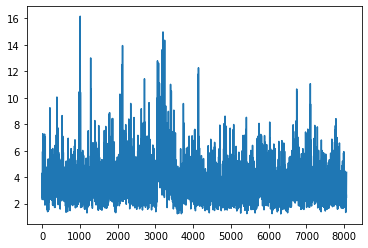

In [ ]:
#gfp calculation
gfp=[]
for video in range(40):
  RMSE_array=[]
  for i in range(len(eeg_data[0][0])):
    v_mean=0
    for j in range(len(eeg_data[0])):
      v_mean=v_mean+eeg_data[video,j,i]
    v_mean=v_mean/len(eeg_data[0])
    squared_error=0
    for j in range(len(eeg_data[0])):
      squared_error=squared_error+(eeg_data[video,j,i]-v_mean)**2
    RMSE=math.sqrt(squared_error/len(eeg_data[0]))
    RMSE_array.append(RMSE)
  #print(len(RMSE_array))
  gfp.append(RMSE_array)
gfp=np.array(gfp)
#print(gfp.shape)
gfp=gfp[0]
gfp=np.transpose(gfp)
print(gfp)
plt.plot([i for i in range(8064)], gfp)

In [ ]:
Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,P3,P7,PO3,O1,Oz,Pz,Fp2,AF4,Fz,F4,F8,FC6,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2 = eeg_data[0][:, 1]
col = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
m = [[0, 0, 0, Fp1, 0, Fp2, 0 , 0, 0],
    [0, 0, 0, AF3, 0, AF4, 0, 0, 0],
    [F7, 0, F3, 0, Fz, 0, F4, 0, F8],
    [0, FC5, 0, FC1, 0, FC2, 0, FC6, 0],
    [T7, 0, C3, 0, Cz, 0, C4, 0, T8],
    [0, CP5, 0, CP1, 0, CP2, 0, CP6, 0],
    [P7, 0, P3, 0, Pz, 0, P4, 0, P8],
    [0, 0, 0, PO3, 0, PO4, 0, 0, 0],
    [0, 0, 0, O1, Oz, O2, 0, 0, 0]]

info = np.array([[i, j] for i in range(9) for j in range(9) if m[i][j] != 0])

In [ ]:
eeg_data=data_[0,0:32,:]

**Kmeans**

In [ ]:

def _mod_kmeans(data, n_states=4, n_inits=10, max_iter=1000, thresh=1e-6,
                random_state=None, verbose=None):
    """The modified K-means clustering algorithm.
    See :func:`segment` for the meaning of the parameters and return
    values.
    """
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(random_state)
    n_channels, n_samples = data.shape
    print("mod kmeans",data.shape)
    # Cache this value for later
    data_sum_sq = np.sum(data ** 2)

    # Select random timepoints for our initial topographic maps
    init_times = random_state.choice(n_samples, size=n_states, replace=False)
    maps = data[:, init_times].T
    maps /= np.linalg.norm(maps, axis=1, keepdims=True)  # Normalize the maps

    prev_residual = np.inf
    for iteration in range(max_iter):
        # Assign each sample to the best matching microstate
        activation = maps.dot(data)
        segmentation = np.argmax(np.abs(activation), axis=0)

        # Recompute the topographic maps of the microstates, based on the
        # samples that were assigned to each state.
        for state in range(n_states):
            idx = (segmentation == state)
            if np.sum(idx) == 0:
                warnings.warn('Some microstates are never activated')
                maps[state] = 0
                continue
           
            # Find largest eigenvector
            # cov = data[:, idx].dot(data[:, idx].T)
            # _, vec = eigh(cov, eigvals=(n_channels - 1, n_channels - 1))
            # maps[state] = vec.ravel()
            maps[state] = data[:, idx].dot(activation[state, idx])
            maps[state] /= np.linalg.norm(maps[state])

        # Estimate residual noise
        act_sum_sq = np.sum(np.sum(maps[segmentation].T * data, axis=0) ** 2)
        residual = abs(data_sum_sq - act_sum_sq)
        residual /= float(n_samples * (n_channels - 1))

        # Have we converged?
        if (prev_residual - residual) < (thresh * residual):
            logger.info('Converged at %d iterations.' % iteration)
            break

        prev_residual = residual
    else:
        warnings.warn('Modified K-means algorithm failed to converge.')

    return maps

In [ ]:
def _corr_vectors(A, B, axis=0):
    """Compute pairwise correlation of multiple pairs of vectors.
    Fast way to compute correlation of multiple pairs of vectors without
    computing all pairs as would with corr(A,B). Borrowed from Oli at Stack
    overflow. Note the resulting coefficients vary slightly from the ones
    obtained from corr due differences in the order of the calculations.
    (Differences are of a magnitude of 1e-9 to 1e-17 depending of the tested
    data).
    Parameters
    ----------
    A : ndarray, shape (n, m)
        The first collection of vectors
    B : ndarray, shape (n, m)
        The second collection of vectors
    axis : int
        The axis that contains the elements of each vector. Defaults to 0.
    Returns
    -------
    corr : ndarray, shape (m,)
        For each pair of vectors, the correlation between them.
    """
    An = A - np.mean(A, axis=axis)
    Bn = B - np.mean(B, axis=axis)
    An /= np.linalg.norm(An, axis=axis)
    Bn /= np.linalg.norm(Bn, axis=axis)
    return np.sum(An * Bn, axis=axis)

In [ ]:
def plot_segmentation(segmentation, data, times, polarity=None):
    """Plot a microstate segmentation.
    Parameters
    ----------
    segmentation : list of int
        For each sample in time, the index of the state to which the sample has
        been assigned.
    times : list of float
        The time-stamp for each sample.
    polarity : list of int | None
        For each sample in time, the polarity (+1 or -1) of the activation.
    """
    gfp = np.std(data, axis=0)
    if polarity is not None:
        gfp *= polarity

    n_states = len(np.unique(segmentation))
    plt.figure(figsize=(6 * np.ptp(times), 2))
    cmap = plt.cm.get_cmap('plasma', n_states)
    plt.plot(times, gfp, color='black', linewidth=1)
    for state, color in zip(range(n_states), cmap.colors):
        plt.fill_between(times, gfp, color=color,
                         where=(segmentation == state))
    norm = mpl.colors.Normalize(vmin=0, vmax=n_states)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    plt.xlabel('Time (s)')
    plt.title('Segmentation into %d microstates' % n_states)
    plt.autoscale(tight=True)
    plt.tight_layout()

In [ ]:
def plot_maps(maps, info):
    """Plot prototypical microstate maps.
    Parameters
    ----------
    maps : ndarray, shape (n_channels, n_maps)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    for i, map in enumerate(maps):
        plt.figure(figsize=(10,10))
        plt.subplot(1, len(maps), i + 1)
        mne.viz.plot_topomap(map, info)
        #plt.title('%d' % i)

In [ ]:
def segment(data, n_states=4, n_inits=10, max_iter=1000, thresh=1e-6,
            normalize=False, min_peak_dist=2, max_n_peaks=10000,
            return_polarity=False, random_state=None, verbose=None):
    
    logger.info('Finding %d microstates, using %d random intitializations' %
                (n_states, n_inits))
    #print("data: ", data.shape)
    if normalize:
        data = zscore(data, axis=1)

    # Find peaks in the global field power (GFP)
    #gfp = np.std(data, axis=0)
    print("GFP shape",gfp.shape)
    peaks, _ = find_peaks(gfp, distance=min_peak_dist)
    n_peaks = len(peaks)
    print("N-peaks: ",n_peaks)

    # Limit the number of peaks by randomly selecting them
    if max_n_peaks is not None:
        max_n_peaks = min(n_peaks, max_n_peaks)
        if not isinstance(random_state, np.random.RandomState):
            random_state = np.random.RandomState(random_state)
        chosen_peaks = random_state.choice(n_peaks, size=max_n_peaks,
                                           replace=False)
        peaks = peaks[chosen_peaks]

    # Cache this value for later
    gfp_sum_sq = np.sum(gfp ** 2)

    # Do several runs of the k-means algorithm, keep track of the best
    # segmentation.
    best_gev = 0
    best_maps = None
    best_segmentation = None
    best_polarity = None
    for _ in range(n_inits):
        maps = _mod_kmeans(data[:, peaks], n_states, n_inits, max_iter, thresh,
                           random_state, verbose)
        #print(maps)
        activation = maps.dot(data)
        segmentation = np.argmax(np.abs(activation), axis=0)
        map_corr = _corr_vectors(data, maps[segmentation].T)
        # assigned_activations = np.choose(segmentations, activation)

        # Compare across iterations using global explained variance (GEV) of
        # the found microstates.
        gev = sum((gfp * map_corr) ** 2) / gfp_sum_sq
        logger.info('GEV of found microstates: %f' % gev)
        if gev > best_gev:
            best_gev, best_maps, best_segmentation = gev, maps, segmentation
            best_polarity = np.sign(np.choose(segmentation, activation))

    if return_polarity:
        return best_maps, best_segmentation, best_polarity, best_gev
    else:
        return best_maps, best_segmentation, best_gev


Finding 4 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 46 iterations.
GEV of found microstates: 0.625205
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.620059
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.625397
mod kmeans (32, 1943)
Converged at 29 iterations.
GEV of found microstates: 0.625368
mod kmeans (32, 1943)
Converged at 18 iterations.
GEV of found microstates: 0.622330
mod kmeans (32, 1943)
Converged at 94 iterations.
GEV of found microstates: 0.623841
mod kmeans (32, 1943)
Converged at 21 iterations.
GEV of found microstates: 0.624910
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.625397
mod kmeans (32, 1943)
Converged at 15 iterations.
GEV of found microstates: 0.625399
mod kmeans (32, 1943)
Converged at 52 iterations.
GEV of found microstates: 0.625368
[[ 0.1884721   0.24376317  0.25708099  0.12205851  0.0359734 

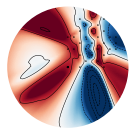

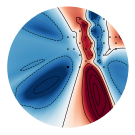

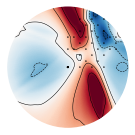

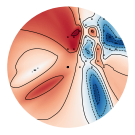

For n_outputs 4 GEV is 0.6253994034251293


Finding 5 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.644261
mod kmeans (32, 1943)
Converged at 20 iterations.
GEV of found microstates: 0.643679
mod kmeans (32, 1943)
Converged at 71 iterations.
GEV of found microstates: 0.645815
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.643890
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.644017
mod kmeans (32, 1943)
Converged at 15 iterations.
GEV of found microstates: 0.645719
mod kmeans (32, 1943)
Converged at 28 iterations.
GEV of found microstates: 0.643859
mod kmeans (32, 1943)
Converged at 17 iterations.
GEV of found microstates: 0.644261
mod kmeans (32, 1943)
Converged at 42 iterations.
GEV of found microstates: 0.641917
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.644090
[[ 0.14376432  0.

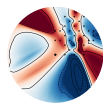

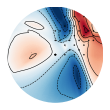

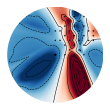

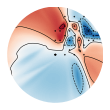

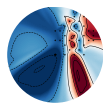

For n_outputs 5 GEV is 0.6458149376725906


Finding 6 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.661462
mod kmeans (32, 1943)
Converged at 16 iterations.
GEV of found microstates: 0.661657
mod kmeans (32, 1943)
Converged at 85 iterations.
GEV of found microstates: 0.662014
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.660885
mod kmeans (32, 1943)
Converged at 23 iterations.
GEV of found microstates: 0.656263
mod kmeans (32, 1943)
Converged at 42 iterations.
GEV of found microstates: 0.660793
mod kmeans (32, 1943)
Converged at 16 iterations.
GEV of found microstates: 0.657421
mod kmeans (32, 1943)
Converged at 23 iterations.
GEV of found microstates: 0.662149
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.652827
mod kmeans (32, 1943)
Converged at 98 iterations.
GEV of found microstates: 0.661693
[[-0.20964876 -0.

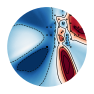

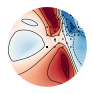

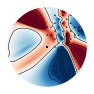

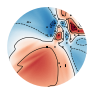

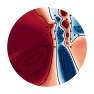

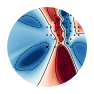

For n_outputs 6 GEV is 0.6621490530801827


Finding 7 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 72 iterations.
GEV of found microstates: 0.672818
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.670674
mod kmeans (32, 1943)
Converged at 54 iterations.
GEV of found microstates: 0.671852
mod kmeans (32, 1943)
Converged at 36 iterations.
GEV of found microstates: 0.671093
mod kmeans (32, 1943)
Converged at 16 iterations.
GEV of found microstates: 0.671132
mod kmeans (32, 1943)
Converged at 19 iterations.
GEV of found microstates: 0.670365
mod kmeans (32, 1943)
Converged at 36 iterations.
GEV of found microstates: 0.673625
mod kmeans (32, 1943)
Converged at 43 iterations.
GEV of found microstates: 0.672564
mod kmeans (32, 1943)
Converged at 21 iterations.
GEV of found microstates: 0.671107
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.672665
[[-0.12926168 -0.

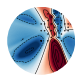

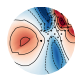

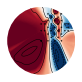

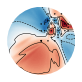

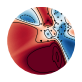

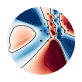

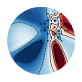

For n_outputs 7 GEV is 0.6736254202680592


Finding 8 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 43 iterations.
GEV of found microstates: 0.680677
mod kmeans (32, 1943)
Converged at 25 iterations.
GEV of found microstates: 0.680440
mod kmeans (32, 1943)
Converged at 50 iterations.
GEV of found microstates: 0.681022
mod kmeans (32, 1943)
Converged at 25 iterations.
GEV of found microstates: 0.680738
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.682326
mod kmeans (32, 1943)
Converged at 15 iterations.
GEV of found microstates: 0.681671
mod kmeans (32, 1943)
Converged at 12 iterations.
GEV of found microstates: 0.681652
mod kmeans (32, 1943)
Converged at 26 iterations.
GEV of found microstates: 0.681114
mod kmeans (32, 1943)
Converged at 40 iterations.
GEV of found microstates: 0.681927
mod kmeans (32, 1943)
Converged at 40 iterations.
GEV of found microstates: 0.681232
[[ 2.26836492e-01

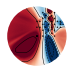

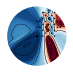

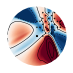

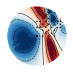

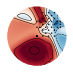

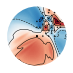

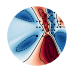

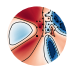

For n_outputs 8 GEV is 0.6823260799619222


Finding 9 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 45 iterations.
GEV of found microstates: 0.688170
mod kmeans (32, 1943)
Converged at 32 iterations.
GEV of found microstates: 0.690256
mod kmeans (32, 1943)
Converged at 29 iterations.
GEV of found microstates: 0.689700
mod kmeans (32, 1943)
Converged at 39 iterations.
GEV of found microstates: 0.689655
mod kmeans (32, 1943)
Converged at 40 iterations.
GEV of found microstates: 0.689370
mod kmeans (32, 1943)
Converged at 51 iterations.
GEV of found microstates: 0.688964
mod kmeans (32, 1943)
Converged at 23 iterations.
GEV of found microstates: 0.689542
mod kmeans (32, 1943)
Converged at 55 iterations.
GEV of found microstates: 0.688886
mod kmeans (32, 1943)
Converged at 47 iterations.
GEV of found microstates: 0.690043
mod kmeans (32, 1943)
Converged at 37 iterations.
GEV of found microstates: 0.689910
[[ 1.38969800e-01

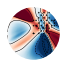

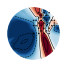

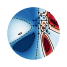

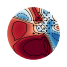

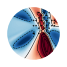

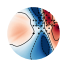

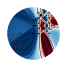

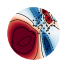

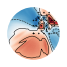

For n_outputs 9 GEV is 0.690256373356071


Finding 10 microstates, using 10 random intitializations
GFP shape (8064,)
N-peaks:  1943
mod kmeans (32, 1943)
Converged at 43 iterations.
GEV of found microstates: 0.696075
mod kmeans (32, 1943)
Converged at 22 iterations.
GEV of found microstates: 0.696176
mod kmeans (32, 1943)
Converged at 34 iterations.
GEV of found microstates: 0.696628
mod kmeans (32, 1943)
Converged at 50 iterations.
GEV of found microstates: 0.696082
mod kmeans (32, 1943)
Converged at 33 iterations.
GEV of found microstates: 0.697113
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.695754
mod kmeans (32, 1943)
Converged at 29 iterations.
GEV of found microstates: 0.696689
mod kmeans (32, 1943)
Converged at 24 iterations.
GEV of found microstates: 0.697211
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.696043
mod kmeans (32, 1943)
Converged at 30 iterations.
GEV of found microstates: 0.696178
[[ 1.64098523e-01

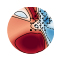

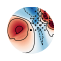

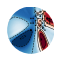

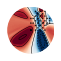

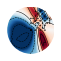

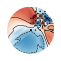

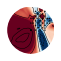

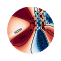

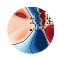

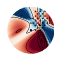

For n_outputs 10 GEV is 0.697210642869056




In [ ]:
for op in range(4,11):
  maps, segmentation, gev_kmeans = segment(eeg_data, n_states=op)
  #print(segmentation)
  print(maps)
  plot_maps(maps, info)
  print(f"For n_outputs {op} GEV is {gev_kmeans}")
  print()
  print()

In [ ]:
#number of samples in each cluster
A_kmeans,B_kmeans,C_kmeans,D_kmeans=0,0,0,0
for i in range(8064):
  if segmentation[i]==0:
    A_kmeans=A_kmeans+1
  if segmentation[i]==1:
    B_kmeans=B_kmeans+1
  if segmentation[i]==2:
    C_kmeans=C_kmeans+1
  if segmentation[i]==3:
    D_kmeans=D_kmeans+1
print(A_kmeans, B_kmeans, C_kmeans,D_kmeans)

2190 1880 1968 2026


In [ ]:
#shannon-Entropy calculation
p_A_kmeans,p_B_kmeans,p_C_kmeans,p_D_kmeans=A_kmeans/8064,B_kmeans/8064,C_kmeans/8064,D_kmeans/8064
print(math.log(4))
ent_kmeans=-p_A_kmeans*math.log(p_A_kmeans)-p_B_kmeans*math.log(p_B_kmeans)-p_C_kmeans*math.log(p_C_kmeans)-p_D_kmeans*math.log(p_D_kmeans)
print(ent_kmeans)

1.3862943611198906
1.3847322796133206


**AAHC**

In [ ]:
def locmax(x):
    """Get local maxima of 1D-array
    Args:
        x: numeric sequence
    Returns:
        m: list, 1D-indices of local maxima
    """

    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

def aahc(data, N_clusters, doplot=False):
    """Atomize and Agglomerative Hierarchical Clustering Algorithm
    AAHC (Murray et al., Brain Topography, 2008)
    Args:
        data: EEG data to cluster, numpy.array (n_samples, n_channels)
        N_clusters: desired number of clusters
        doplot: boolean, plot maps
    Returns:
        maps: n_maps x n_channels (numpy.array)
    """

    def extract_row(A, k):
        v = A[k,:]
        A_ = np.vstack((A[:k,:],A[k+1:,:]))
        return A_, v

    def extract_item(A, k):
        a = A[k]
        A_ = A[:k] + A[k+1:]
        return A_, a

    #print("\n\t--- AAHC ---")
    nt, nch = data.shape

    # --- get GFP peaks ---
    gfp = data.std(axis=1)
    gfp_peaks = locmax(gfp)
    #gfp_peaks = gfp_peaks[:100]
    #n_gfp = gfp_peaks.shape[0]
    gfp2 = np.sum(gfp**2) # normalizing constant in GEV

    # --- initialize clusters ---
    maps = data[gfp_peaks,:]
    # --- store original gfp peaks and indices ---
    cluster_data = data[gfp_peaks,:]
    #n_maps = n_gfp
    n_maps = maps.shape[0]
    print("\t[+] Initial number of clusters: {:d}\n".format(n_maps))

    # --- cluster indices w.r.t. original size, normalized GFP peak data ---
    Ci = [[k] for k in range(n_maps)]

    # --- main loop: atomize + agglomerate ---
    while (n_maps > N_clusters):
        s = "\r{:s}\r\t\tAAHC > n: {:d} => {:d}".format(80*" ", n_maps, n_maps-1)
        #stdout.write(s); stdout.flush()
        #print("\n\tAAHC > n: {:d} => {:d}".format(n_maps, n_maps-1))

        # --- correlations of the data sequence with each cluster ---
        m_x, s_x = data.mean(axis=1, keepdims=True), data.std(axis=1)
        m_y, s_y = maps.mean(axis=1, keepdims=True), maps.std(axis=1)
        s_xy = 1.*nch*np.outer(s_x, s_y)
        C = np.dot(data-m_x, np.transpose(maps-m_y)) / s_xy

        # --- microstate sequence, ignore polarity ---
        L = np.argmax(C**2, axis=1)

        # --- GEV (global explained variance) of cluster k ---
        gev = np.zeros(n_maps)
        for k in range(n_maps):
            r = L==k
            gev[k] = np.sum(gfp[r]**2 * C[r,k]**2)/gfp2

        # --- merge cluster with the minimum GEV ---
        imin = np.argmin(gev)
        #print("\tre-cluster: {:d}".format(imin))

        # --- N => N-1 ---
        maps, _ = extract_row(maps, imin)
        Ci, reC = extract_item(Ci, imin)
        re_cluster = []  # indices of updated clusters
        #C_sgn = np.zeros(nt)
        for k in reC:  # map index to re-assign
            c = cluster_data[k,:]
            m_x, s_x = maps.mean(axis=1, keepdims=True), maps.std(axis=1)
            m_y, s_y = c.mean(), c.std()
            s_xy = 1.*nch*s_x*s_y
            C = np.dot(maps-m_x, c-m_y)/s_xy
            inew = np.argmax(C**2) # ignore polarity
            #C_sgn[k] = C[inew]
            re_cluster.append(inew)
            Ci[inew].append(k)
        n_maps = len(Ci)

        # --- update clusters ---
        re_cluster = list(set(re_cluster)) # unique list of updated clusters

        ''' re-clustering by modified mean
        for i in re_cluster:
            idx = Ci[i]
            c = np.zeros(nch) # new cluster average
            for k in idx: # add to new cluster, polarity according to corr. sign
                if (C_sgn[k] >= 0):
                    c += cluster_data[k,:]
                else:
                    c -= cluster_data[k,:]
            c /= len(idx)
            maps[i] = c
            #maps[i] = (c-np.mean(c))/np.std(c) # normalize the new cluster
        del C_sgn
        '''

        # re-clustering by eigenvector method
        for i in re_cluster:
            idx = Ci[i]
            Vt = cluster_data[idx,:]
            Sk = np.dot(Vt.T, Vt)
            evals, evecs = np.linalg.eig(Sk)
            c = evecs[:, np.argmax(np.abs(evals))]
            c = np.real(c)
            maps[i] = c/np.sqrt(np.sum(c**2))

    print()
    return maps

In [ ]:
for op in range (4,11):
  maps = aahc(eeg_data.T, op)
  print(maps)
  gfp_sum_sq=np.sum(gfp**2)
  activation=maps.dot(eeg_data)
  seg=np.argmax(np.abs(activation),axis=0)
  #print(seg)
  map_corr=_corr_vectors(eeg_data,maps[seg].T)
  gev_aahc=sum((gfp*map_corr)**2)/gfp_sum_sq
  print(f"For n_outputs {op} GEV is {gev_aahc}")
  print()
  print()


	[+] Initial number of clusters: 1943


[[-0.23664495 -0.23036494 -0.19926085 -0.18158667 -0.04085676 -0.04319517
   0.02444181 -0.06593079  0.12772105  0.16221699  0.28609428  0.18751861
   0.26753462  0.2336596   0.20872474  0.20143745 -0.29230679 -0.19374602
  -0.18274693 -0.24780479 -0.24007907 -0.1389186  -0.12685641  0.03834067
  -0.00066544 -0.0483446   0.02384666  0.08566179  0.18942262  0.03298716
   0.2147058   0.18499493]
 [ 0.20938758  0.26559253  0.28871609  0.26535031  0.0735968   0.06445124
   0.19283994  0.25958294  0.110718   -0.00479197 -0.15691992 -0.01942382
  -0.05698284 -0.07624876 -0.16495278 -0.1135216   0.19052843 -0.00516923
   0.16959631  0.16898245  0.02258737 -0.08492861  0.11719752 -0.00531407
  -0.15884201 -0.22418623 -0.16910376 -0.09887028 -0.3500876  -0.16253964
  -0.31578811 -0.23145628]
 [-0.13011604 -0.22161163 -0.24646869 -0.03073324  0.03345944 -0.17604611
  -0.0834542   0.06210162  0.07860213  0.00112546  0.1986653   0.24013335
   0.17716942  0.2

**SOFM**

**4 microstates**

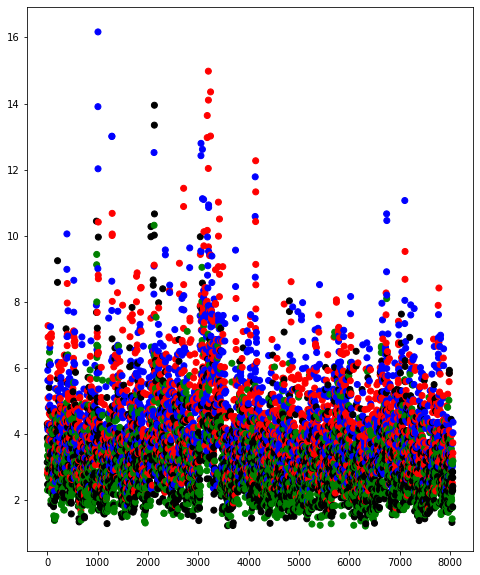

In [ ]:
#SOFM
from neupy import algorithms
import seaborn as sns
#norm = np.linalg.norm(eeg_data)
#eeg_data=eeg_data/norm
#print(eeg_data[:10,:8])
eeg_data1=eeg_data.T
sofm = algorithms.SOFM(n_inputs=32, n_outputs=4, step=0.06,learning_radius=0)
sofm.train(eeg_data1,epochs=100)
clusters = sofm.predict(eeg_data1)

predicted_output=[]
sofm_prediction=[]
for i in range(8064):
  if clusters[i][0]==1:
    predicted_output.append("blue") #cluster1
    sofm_prediction.append(0)
  elif clusters[i][1]==1:
    predicted_output.append("red") #cluster2
    sofm_prediction.append(1)
  elif clusters[i][2]==1:
    predicted_output.append("green") #cluster3
    sofm_prediction.append(2)
  elif clusters[i][3]==1:
    predicted_output.append("black") #cluster4
    sofm_prediction.append(3)
#print(predicted_output)
plt.figure(figsize=(8, 10))
plt.scatter(range(len(gfp)),gfp,color=predicted_output)




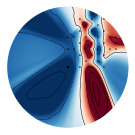

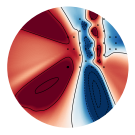

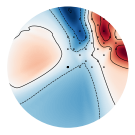

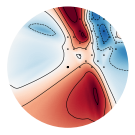

In [ ]:
sofm_maps=sofm.weight.T
plot_maps(sofm_maps,info)

In [ ]:
A_sofm,B_sofm,C_sofm,D_sofm=0,0,0,0
for i in range(8064):
  if sofm_prediction[i]==0:
    A_sofm=A_sofm+1
  if sofm_prediction[i]==1:
    B_sofm=B_sofm+1
  if sofm_prediction[i]==2:
    C_sofm=C_sofm+1
  if sofm_prediction[i]==3:
    D_sofm=D_sofm+1
print(A_sofm, B_sofm, C_sofm,D_sofm)

1699 1924 2117 2324


In [ ]:
p_A_sofm,p_B_sofm,p_C_sofm,p_D_sofm=A_sofm/8064,B_sofm/8064,C_sofm/8064,D_sofm/8064
#shannon-Entropy calculation
print(math.log(4))
ent_sofm=-p_A_sofm*math.log(p_A_sofm)-p_B_sofm*math.log(p_B_sofm)-p_C_sofm*math.log(p_C_sofm)-p_D_sofm*math.log(p_D_sofm)
print(ent_sofm)

1.3862943611198906
1.3796752019483343


In [ ]:
#GEV calculation
gfp_sum_sq=np.sum(gfp**2)
activation=sofm_maps.dot(eeg_data)
seg=np.argmax(np.abs(activation),axis=0)
np.set_printoptions(threshold=sys.maxsize)
#print(seg)
map_corr=_corr_vectors(eeg_data,sofm_maps[sofm_prediction].T)
gev_sofm=sum((gfp*map_corr)**2)/gfp_sum_sq
print(gev_sofm)

0.5056232840895795


**Scalable**

In [ ]:
#SOFM
from neupy import algorithms
import seaborn as sns
#norm = np.linalg.norm(eeg_data)
#eeg_data=eeg_data/norm
#print(eeg_data[:10,:8])
eeg_data1=eeg_data.T
for op in range (4,11):
  sofm = algorithms.SOFM(n_inputs=32, n_outputs=op, step=0.06,learning_radius=0)
  sofm.train(eeg_data1,epochs=100)
  clusters = sofm.predict(eeg_data1)
  sofm_prediction=[]
  for j in range (8064):
    for k in range(0,op):
      if clusters[j][k]==1:
        sofm_prediction.append(k)
  sofm_maps=sofm.weight.T
  #print(sofm_maps)
  print(op,"microstates :")
  #plot_maps(sofm_maps,info)
  gfp_sum_sq=np.sum(gfp**2)
  activation=sofm_maps.dot(eeg_data)
  seg=np.argmax(np.abs(activation),axis=0)
  map_corr=_corr_vectors(eeg_data,sofm_maps[sofm_prediction].T)
  gev_sofm=sum((gfp*map_corr)**2)/gfp_sum_sq
  print(f"For n_outputs {op} GEV is {gev_sofm}")
  print()
  print()

4 microstates :
For n_outputs 4 GEV is 0.5056232840895795




5 microstates :
For n_outputs 5 GEV is 0.5460711778352214




6 microstates :
For n_outputs 6 GEV is 0.5611922978917173




7 microstates :
For n_outputs 7 GEV is 0.5775817956672868




8 microstates :
For n_outputs 8 GEV is 0.5811585316103259




9 microstates :
For n_outputs 9 GEV is 0.5888481970645624




10 microstates :
For n_outputs 10 GEV is 0.5981925187567181




**SOFM on peaks**

In [ ]:

peaks = locmax(gfp)

eeg_data1=eeg_data.T
norm = np.linalg.norm(eeg_data)
eeg_data_n=eeg_data/norm
for op in range (4,11):
  sofm = algorithms.SOFM(n_inputs=32, n_outputs=op, step=0.06,learning_radius=0)
  ip_eeg=eeg_data[:,peaks]

  sofm.train(ip_eeg.T,epochs=100)
  clusters = sofm.predict(eeg_data.T)
  sofm_maps=sofm.weight.T
  sofm_maps /= np.linalg.norm(sofm_maps, axis=1, keepdims=True) 
  #print(sofm_maps)
  sofm_pred=[]
  for i in range(8064):
    for j in range(op):
      if clusters[i][j]==1:
        sofm_pred.append(j)

  gfp_sum_sq=np.sum(gfp**2)
  activation=sofm_maps.dot(eeg_data)
  seg=np.argmax(np.abs(activation),axis=0)
  map_corr=_corr_vectors(eeg_data,sofm_maps[sofm_pred].T)
  gev_sofm=sum((gfp*map_corr)**2)/gfp_sum_sq
  print(f"For n_outputs {op} GEV is {gev_sofm}")
  print()
  print()

For n_outputs 4 GEV is 0.5304902570181259




For n_outputs 5 GEV is 0.5631415304781904




For n_outputs 6 GEV is 0.5709927223305




For n_outputs 7 GEV is 0.581749773796031




For n_outputs 8 GEV is 0.5870732465137991




For n_outputs 9 GEV is 0.5936454778041234




For n_outputs 10 GEV is 0.5985559630724665


